In [1]:
%reset -f

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

In [83]:
data = pd.read_csv('../data/dataset.csv', sep=',')

In [71]:
data.head(1)

,numinscricao,classificacao,opcao_curso_2,opcao_3_curso,nota_final,nota_cg,nota_etapa_1,nota_ce,nota_redacao,nota_etapa_2,opcao_curso_1,id_referencia_curso,nome_referencia_curso,ano,idade,aprovado,egresso_publica
0,6659880-0,1,No,No,74.201,67.857,67.857,64.0,16.55,80.545,4069,4069,Odontologia - Integral - Manaus,2019,19,1,0


In [41]:
df = data.copy()

In [42]:
def reduce_name(name):
  name = name.lower()
  splited_name = name.split('-')
  name = splited_name[0].rstrip()
  return name

df["nome_referencia_curso"] = df["nome_referencia_curso"].apply(reduce_name)

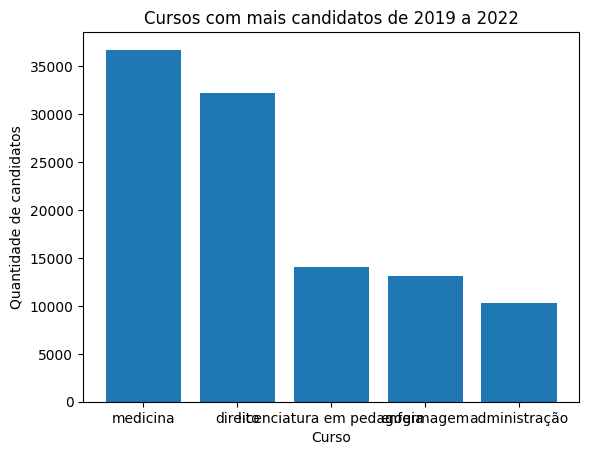

In [52]:
frequency = df['nome_referencia_curso'].value_counts()
plt.bar(frequency.head(5).index, frequency.head(5))
plt.xlabel('Curso')
plt.ylabel('Quantidade de candidatos')
plt.title('Cursos com mais candidatos de 2019 a 2022')
plt.show()

In [53]:
le = LabelEncoder()
df["nome_referencia_curso"] = le.fit_transform(df["nome_referencia_curso"])

In [76]:
features = ['nota_final', 'nota_cg', 
            'nota_etapa_1', 'nota_ce', 'nota_redacao', 
            'nota_etapa_2', 'egresso_publica', 'aprovado', 
            'nome_referencia_curso']
X = df[features]
y = df['idade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 4.2076780769617965


In [79]:
%reset -f

In [85]:
approved = data[data['aprovado'] == 1]

grouby_year_course = approved.groupby(['nome_referencia_curso', 'ano'])

notas_corte = grouby_year_course.last()['nota_final']

series_temporais = {}
for course, grades in notas_corte.groupby(level=0):
    series_temporais[course] = grades

models = {}
for curso, serie_temporal in series_temporais.items():
    model = SARIMAX(serie_temporal, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    trained = model.fit(disp=False)
    models[curso] = trained

predictions_next_year = {}
for course, model in models.items():
    prediction = model.get_forecast(steps=1).predicted_mean.values[0]
    predictions_next_year[course] = prediction

c:\Users\SAMSUNG\Documents\GitHub\data-mining-macro-uea\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SAMSUNG\Documents\GitHub\data-mining-macro-uea\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SAMSUNG\Documents\GitHub\data-mining-macro-uea\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\SAMSUNG\Documents\GitHub\data-mining-macro-uea\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parame

In [87]:
print('Previsões para 2023')
print(predictions_next_year['Medicina - Integral - Manaus'])

Previsões para 2023
53.479
